In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pickle


import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(0)


blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)

In [2]:
from src.model import SSCNetwork
from Network_Definition.forward import forward
from Network_Definition.parameters import network_parameters
from src.utils.general import make_input, LatentSpace, get_ordered_indices, test_network, get_latent_accuracy, get_signal_to_noise_ratio

In [3]:
network_model = {}
network_model["forward"] = forward

recording_parameters = {}
recording_parameters["regions"] = ["hidden", "output_hat", "output"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = ["hidden_hidden"]
recording_parameters["rate_connectivity"] = 100



input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 0

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

In [4]:
input, input_episodes, input_latents = make_input(**input_params)
network = SSCNetwork(network_parameters, recording_parameters, network_model)

In [5]:
print_rate = 50
with torch.no_grad():
    for day in range(input_params["num_days"]):
        if day%print_rate == 0:
            print(day)
        network(input[day], debug=False)

0


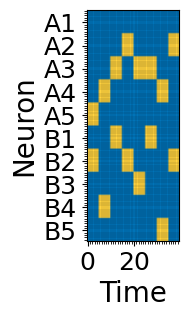

In [6]:
hidden = torch.stack(network.activity_recordings["hidden"], dim=0)[network.awake_indices][:input_params["day_length"]//2, :100].reshape(-1, 100).T

fig = plt.figure(figsize=(3, 3))



plt.imshow(hidden, cmap=blue_yellow, vmin=0, vmax=1)


# Set ticks at pixel boundaries
plt.xticks(np.arange(0, 40, 1), minor=True)
plt.yticks(np.arange(0, 100, 1), minor=True)
plt.grid(which="minor", color="black", linestyle='-', linewidth=0.1)


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)

plt.savefig("Figures/SVG/2B1.svg", dpi=300, transparent=True)



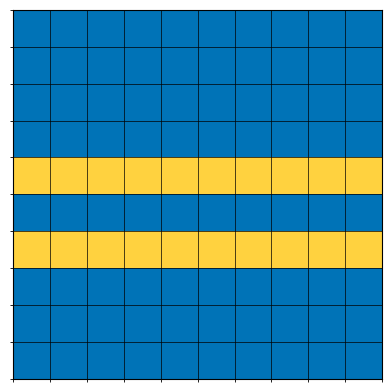

In [7]:
plt.imshow(hidden[:, 0].reshape((-1, 10)), cmap=blue_yellow, vmin=0, vmax=1)

# --- Grid setup ---
# Set minor ticks at pixel boundaries
plt.xticks(np.arange(-0.5, 10, 1), minor=True)
plt.yticks(np.arange(-0.5, 10, 1), minor=True)

# Draw gridlines at minor ticks
plt.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

plt.xticks([])
plt.yticks([])

plt.savefig("Figures/SVG/1C1.svg", dpi=300, transparent=True)
plt.show()

In [13]:
network_model = {}
network_model["forward"] = forward

recording_parameters = {}
recording_parameters["regions"] = ["hidden", "output_hat", "output"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = ["hidden_hidden"]
recording_parameters["rate_connectivity"] = 100



input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

In [14]:
input, input_episodes, input_latents = make_input(**input_params)
network = SSCNetwork(network_parameters, recording_parameters, network_model)

In [15]:
print_rate = 50
with torch.no_grad():
    for day in range(input_params["num_days"]):
        if day%print_rate == 0:
            print(day)
        network(input[day], debug=False)
hidden = torch.stack(network.activity_recordings["hidden"], dim=0)[network.awake_indices][:input_params["day_length"]//2, :100].reshape(-1, 100).T


0


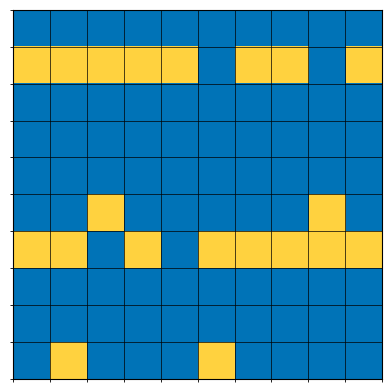

In [16]:
plt.imshow(hidden[:, 0].reshape((-1, 10)), cmap=blue_yellow, vmin=0, vmax=1)

# --- Grid setup ---
# Set minor ticks at pixel boundaries
plt.xticks(np.arange(-0.5, 10, 1), minor=True)
plt.yticks(np.arange(-0.5, 10, 1), minor=True)

# Draw gridlines at minor ticks
plt.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

plt.xticks([])
plt.yticks([])

plt.savefig("Figures/SVG/4C1.svg", dpi=300, transparent=True)
plt.show()